## <font color='#0000FF'>MSC_DA_CA2 - INTEGRATEDCA2<font color='#1ABC9D'>
### <font color='#'>**Advanced Data Analytics  & Big Data Storage and Processing**
### <font color='#1ABC9C'>**Lecturer(s): David McQuaid and Muhammad Iqbal**
------
<font color='#1ABC9C'>**Student name / ID** // Rosilene Francisca da Silva - 2021090

### Data Integration and Preprocessing: Use Apache Spark to populate MySQL databases with large datasets efficiently. 
This process includes data integration and preprocessing, making it easier to manage data effectively.

### Configure Apache Spark
Start Spark Session:
Set up PySpark, including necessary packages for MySQL connections.

"The dataset used in this analysis, ProjectTweets.csv, was provided by Professor [McQuaid] via the Moodle [https://moodle.cct.ie/mod/assign/view.php?id=44089]course [MSc in Data Analytics] CCT College Dublin on 18 April 2024."

The dataset is guaranteed to have an organised schema, dependable transactional integrity, strong query capabilities, and simple integration with Apache Spark by selecting MySQL over a NoSQL database. All of these advantages combine to make MySQL the superior option for this particular task of populating the information and doing further analytical processing.

In [ ]:
Don't run

In [3]:
spark.stop()

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import os

spark = SparkSession.builder \
    .appName("Database Comparative Analysis") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "2") \
    .config("spark.dynamicAllocation.maxExecutors", "100") \
    .config("spark.sql.shuffle.partitions", "1000") \
    .config("spark.jars", "/home/hduser/Downloads/mysql-connector-j-8.0.33.jar") \
    .getOrCreate()

24/05/11 19:12:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/11 19:12:25 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [5]:
spark

In [6]:
import py4j
print(py4j.__version__)

0.10.9.7


Rationale:
This PySpark setup is designed to process data during a database comparison in an effective and scalable manner. With the application name "Database Comparative Analysis," the SparkSession is created, and backward compatibility with timestamp formats is guaranteed by the legacy time parser policy. In order to efficiently handle huge data volumes, the memory configurations for the executors and driver are set to 8 GB each. Moreover, having 4 cores per executor optimises parallel processing.

By dynamically allocating resources according to workload requirements, the cluster can grow from a minimum of 2 executors to a maximum of 100. Large dataset data shuffling speed is enhanced by increasing the shuffle divisions to 1000, which reduces execution time. 

Furthermore, smooth connectivity between Spark and MySQL for direct data intake and analysis is ensured by including the MySQL JDBC connector jar. This setup offers a scalable and highly effective environment appropriate for large-scale database comparison analysis projects.

#### Before attempting to read the data, let's test reading data or just establish a connection to identify if has any issue

In [7]:
# Test loading a simple query to ensure connectivity
try:
    jdbc_df = spark.read.format("jdbc").option("url", "jdbc:mysql://localhost/twitter_data").option(
        "driver", "com.mysql.cj.jdbc.Driver").option("dbtable", "tweet_details").option(
        "user", "root").option("password", "password").load()
    jdbc_df.show(1)
    print("Connection established successfully.")
    
except Exception as e:
    print("An error occurred:", e)

+---+----------+-------------------+------------+-------------+--------------------+
| id|   user_id|               date|query_status|  user_handle|          tweet_text|
+---+----------+-------------------+------------+-------------+--------------------+
|  1|1467810672|2009-04-06 22:19:49|    NO_QUERY|scotthamilton|is upset that he ...|
+---+----------+-------------------+------------+-------------+--------------------+
only showing top 1 row

Connection established successfully.


### Load the data from MySQL into a new DataFrame
The Database `twitter_data` was created on MySQL following the `tweet_details`table.  
Also defined and renamed the column names as "id", "user_id", "date", "query_status", "user_handle", and "tweet_text".

In [8]:
# Load the data from MySQL into a new DataFrame
mysql_df = spark.read.format("jdbc").options(
    url="jdbc:mysql://localhost/twitter_data",
    driver="com.mysql.cj.jdbc.Driver",
    dbtable="tweet_details",
    user="root",
    password="password"
).load()

# Show the first few rows of the DataFrame to verify the data
mysql_df.show(2)

+---+----------+-------------------+------------+-------------+--------------------+
| id|   user_id|               date|query_status|  user_handle|          tweet_text|
+---+----------+-------------------+------------+-------------+--------------------+
|  1|1467810672|2009-04-06 22:19:49|    NO_QUERY|scotthamilton|is upset that he ...|
|  2|1467810917|2009-04-06 22:19:53|    NO_QUERY|     mattycus|@Kenichan I dived...|
+---+----------+-------------------+------------+-------------+--------------------+
only showing top 2 rows



This code loaded the data from the tweet_details table in MySQL into a new DataFrame called mysql_df. As the data was displayed correctly, it indicates that the data was successfully read to MySQL from PySpark.

#### Verify the DataFrame
After load the dataset, it’s a good idea to check the type and first few rows of the DataFrame to ensure that everything is loaded correctly.

In [9]:
# Print DataFrame schema
mysql_df.printSchema()

mysql_df.show(5, truncate=True)

root
 |-- id: integer (nullable = true)
 |-- user_id: long (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- query_status: string (nullable = true)
 |-- user_handle: string (nullable = true)
 |-- tweet_text: string (nullable = true)



+---+----------+-------------------+------------+-------------+--------------------+
| id|   user_id|               date|query_status|  user_handle|          tweet_text|
+---+----------+-------------------+------------+-------------+--------------------+
|  1|1467810672|2009-04-06 22:19:49|    NO_QUERY|scotthamilton|is upset that he ...|
|  2|1467810917|2009-04-06 22:19:53|    NO_QUERY|     mattycus|@Kenichan I dived...|
|  3|1467811184|2009-04-06 22:19:57|    NO_QUERY|      ElleCTF|my whole body fee...|
|  4|1467811193|2009-04-06 22:19:57|    NO_QUERY|       Karoli|@nationwideclass ...|
|  5|1467811372|2009-04-06 22:20:00|    NO_QUERY|     joy_wolf|@Kwesidei not the...|
+---+----------+-------------------+------------+-------------+--------------------+
only showing top 5 rows



#### Dataframe Information
Show the number of rows and columns.

In [10]:
num_rows = mysql_df.count()
num_columns = len(mysql_df.columns)
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")

Number of rows: 1599999, Number of columns: 6


With 1,599,999 rows and 7 columns overall, the dataset has a sizable amount of data that may be thoroughly examined. Each row contains particular information possibly connected to tweets, with seven columns reflecting different dataset aspects. These features include numerical and categorical data. This dataset's extensive structure makes it possible to perform significant exploratory data analysis (EDA) and gain important insights about user behaviour and data patterns. It also makes it possible to perform more complex analysis or machine learning activities.

### Data Pre-Processing in PySpark

#### Checking for missing Values

In [11]:
# Initialize a flag to track whether missing values are found
from pyspark.sql.functions import col
missing_values_found = False

for column in mysql_df.columns:
    missing_count = mysql_df.filter(col(column).isNull() | (col(column) == '')).count()
    if missing_count > 0:
        print(f"Column {column} has {missing_count} missing values")
        missing_values_found = True

# Check the flag after checking all columns, and print a message if no missing values were found
if not missing_values_found:
    print("No missing values found in any column.")

No missing values found in any column.


Based on output the dataset there is no missing values.

In [12]:
# Displaying dtypes of columns
mysql_df.dtypes

[('id', 'int'),
 ('user_id', 'bigint'),
 ('date', 'timestamp'),
 ('query_status', 'string'),
 ('user_handle', 'string'),
 ('tweet_text', 'string')]

From the output the DataFrame schema, the columns `id` and `user_id` are numerical. 
The column `date`  has a type of timestamp, meaning it's a timestamp (or datetime) field, columns like `query_status` `user_handle`, and `tweet_text` has a type of string, meaning it's a textual field (or varchar in SQL).

#### Displaying some columns

In [13]:
mysql_df.select('user_id').show(n=5, truncate=False)

+----------+
|user_id   |
+----------+
|1467810672|
|1467810917|
|1467811184|
|1467811193|
|1467811372|
+----------+
only showing top 5 rows



In [14]:
mysql_df.select('date').show(n=5, truncate=False)

+-------------------+
|date               |
+-------------------+
|2009-04-06 22:19:49|
|2009-04-06 22:19:53|
|2009-04-06 22:19:57|
|2009-04-06 22:19:57|
|2009-04-06 22:20:00|
+-------------------+
only showing top 5 rows



The output illustrates the temporal character of the data by showing the first five rows of the date column from the dataset. Each entry in the date column is a timestamp indicating when a particular event, such as a tweet, occurred.

#### Using the.agg() method and the aggregation functions min and max to find the earliest and latest dates will print the first and last tweet dates. 

In [15]:
# Import Aggregation Functions
from pyspark.sql import functions as F

# Finding the first and last tweet dates
first_last_dates = mysql_df.agg(
    F.min("date").alias("first_date"),
    F.max("date").alias("last_date")
).collect()[0]

first_date = first_last_dates["first_date"]
last_date = first_last_dates["last_date"]

print(f"First tweet date: {first_date}")
print(f"Last tweet date: {last_date}")

First tweet date: 2009-04-06 22:19:49
Last tweet date: 2009-06-25 10:28:31


The earliest and latest timestamps for tweets suggest that the dataset covers the period of April 6, 2009, to June 25, 2009. The last tweet was sent out on June 25, 2009, at 10:28:31, and the first one was sent out on April 6, 2009, at 22:19:49. 

According to this, the dataset includes tweets from over three months' worth of time, giving it a temporal range that is appropriate for studying tweet patterns and trends during that time. The outcome helps to clarify the historical bounds of the dataset and directs further data analysis techniques.

In [16]:
# Selecting multiple columns
mysql_df.select(['user_handle','tweet_text']).show(n=5, truncate=False)

+-------------+---------------------------------------------------------------------------------------------------------------+
|user_handle  |tweet_text                                                                                                     |
+-------------+---------------------------------------------------------------------------------------------------------------+
|scotthamilton|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!|
|mattycus     |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                      |
|ElleCTF      |my whole body feels itchy and like its on fire                                                                 |
|Karoli       |@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. |
|joy_wolf     |@Kwesidei not the whole crew                                                             

The dataset's first rows provide insight into the `user_handle` and `tweet_text` columns. The user_handle column contains Twitter handles that indicate who wrote each tweet, but the tweet_text column has the actual text content of each tweet. For example, user scotthamilton complains about not being able to update Facebook via text, whereas mattycus describes diving for a ball. Other tweets show personal discomfort (ElleCTF), bewilderment (Karoli), and interactions with other users (joy_wolf). This selection captures various user moods and activities on Twitter within the dataset's duration, emphasising the diversity of content, which ranges from personal updates to social interactions. The truncate=False argument guarantees that the complete content of each tweet is displayed without truncation, providing a preview of the user's tweet interactions.

#### Data Distribution
Count distinct values of a categorical column.

In [19]:
# Selecting 'query_status' column
mysql_df.groupBy("query_status").count().show(10)

+------------+-------+
|query_status|  count|
+------------+-------+
|    NO_QUERY|1599999|
+------------+-------+



The dataset's `query_status` column. In this instance, the output indicates that the query_status of NO_QUERY applies to all 1,599,999 tweets. This suggests that the query_status column has a consistent value across all rows, indicating that the field was not meaningfully used in the dataset or that none of the tweets were connected to any particular search query. The consistency shows that, absent other columns or contextual information, the column might not be pertinent for more investigation. All things considered, this discovery can direct data analysts to concentrate on other columns for significant insights while taking into account possible drop this column from further studies.

In [21]:
# Selecting 'user_handle' column
mysql_df.groupBy("user_handle").count().show(10)

+---------------+-----+
|    user_handle|count|
+---------------+-----+
|     megan_rice|   15|
|         MeghTW|    1|
|stranger_danger|   14|
|       kyrabeth|    1|
|    lovelylivxo|   16|
|      tink68113|    1|
|     Svalentyna|    1|
|     bakerbelle|    1|
|  somethingalex|    1|
|     sexy_ass_T|    1|
+---------------+-----+
only showing top 10 rows



The tweet count of distinct users is calculated by grouping the dataset by the `user_handle` column and counting the number of tweets linked with each user. The first ten rows of the output reveal a unique Twitter user and the number of tweets they have sent. For example, megan_rice has 15 tweets, stranger_danger has 14, and lovelylivxo has 16, yet MeghTW, kyrabeth, so on each have only one tweet. This distribution shows that, while some individuals are frequent tweeters, others have a low presence in the dataset. 

#### Summary Statistics
Generate summary statistics

In [22]:
# Basic statistics
mysql_df.describe().show()

24/05/11 19:16:41 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+--------------------+------------+--------------------+--------------------+
|summary|               id|             user_id|query_status|         user_handle|          tweet_text|
+-------+-----------------+--------------------+------------+--------------------+--------------------+
|  count|          1599999|             1599999|     1599999|             1599999|             1599999|
|   mean|         800000.0|1.9988178841753244E9|        null| 4.325887521835714E9|                null|
| stddev|461880.0710141109| 1.935756789172917E8|        null|5.162733218454889E10|                null|
|    min|                1|          1467810672|    NO_QUERY|        000catnap000|                 ...|
|    max|          1599999|          2329205794|    NO_QUERY|          zzzzeus111|ï¿½ï¿½ï¿½ï¿½ï¿½ß§...|
+-------+-----------------+--------------------+------------+--------------------+--------------------+



The gives summary statistics for the dataset, shedding light on the distribution and features of each column. 

With a mean of 800,000.0 and a standard deviation of roughly 461,880, the id column shows a well-distributed set of unique identifiers ranging from 1 to 1,599,999. With a mean of almost 1.998 billion, the user_id column, which represents unique user identifiers, ranges from 1,467,810,672 to 2,329,205,794. All rows in the query_status column have the same value, NO_QUERY. The Twitter `user_handle` column span from 000catnap000 to zzzzeus111, indicating a wide range of users. 
Finally, a variety of text data are contained in the tweet_text column, including special characters that are evident in the maximum value ï¿½ï¿½ï¿½ï¿½ß§..., which may be indicative of encoding problems. A glimpse of the data distribution is given by the summary, which shows that although most columns are diverse and well-populated, the `query_status` column is uniform, and special characters would need to be cleaned up.

#### Correlation Analysis
Find correlations between numerical columns.

In [23]:
# List of numerical columns
numerical_columns = [col for col, dtype in mysql_df.dtypes if dtype in ('int', 'bigint', 'double', 'float')]
print(f"Numerical columns: {numerical_columns}")

Numerical columns: ['id', 'user_id']


In [24]:
# Summary statistics only for numerical columns
mysql_df.select(numerical_columns).describe().show()

+-------+-----------------+--------------------+
|summary|               id|             user_id|
+-------+-----------------+--------------------+
|  count|          1599999|             1599999|
|   mean|         800000.0|1.9988178841753244E9|
| stddev|461880.0710141109| 1.935756789172917E8|
|    min|                1|          1467810672|
|    max|          1599999|          2329205794|
+-------+-----------------+--------------------+



In [25]:
# Calculate correlations between numerical columns
from pyspark.sql.functions import corr

for column1 in numerical_columns:
    for column2 in numerical_columns:
        if column1 != column2:
            correlation = mysql_df.select(corr(column1, column2)).first()[0]
            print(f"Correlation between {column1} and {column2}: {correlation}")

Correlation between id and user_id: 0.22304937463402058


Correlation between user_id and id: 0.22304937463402053


There is roughly a 0.223 correlation between `id` and `user_id`. Although there is a linear link between the two columns, it is not very strong, as indicated by the slight positive correlation between id and user_id. This discovery may help direct future research or data modelling by providing insight into the distribution of data and user behaviour.

#### Adding a New Column with the current timestamp & Extract only those tweets that contain the keyword "summer" in the tweet_text column.
The `inserted_at` column will contain the timestamp indicating when each row was processed.

In [26]:
# Filtering tweets containing a specific keyword 'summer'
filtered_df = mysql_df.filter(mysql_df.tweet_text.contains("summer"))

# Add a current timestamp column for the insert time
from pyspark.sql.functions import current_timestamp

final_df = filtered_df.withColumn("inserted_at", current_timestamp())

# Select only the desired columns and print it
final_df.select("date", "tweet_text", "inserted_at").show(10, truncate=True)

+-------------------+--------------------+--------------------+
|               date|          tweet_text|         inserted_at|
+-------------------+--------------------+--------------------+
|2009-04-06 22:27:00|@jacobsummers Sor...|2024-05-11 19:17:...|
|2009-04-06 23:40:34|@kimmyawesome Ohh...|2024-05-11 19:17:...|
|2009-04-06 23:48:30|It's official! I'...|2024-05-11 19:17:...|
|2009-04-07 00:12:36|ok my TWEET PEEP ...|2024-05-11 19:17:...|
|2009-04-07 00:13:15|summer camp or su...|2024-05-11 19:17:...|
|2009-04-07 00:34:43|Downy weather  Wh...|2024-05-11 19:17:...|
|2009-04-07 00:35:12|Craaaaap. My Macb...|2024-05-11 19:17:...|
|2009-04-07 00:41:46|@dadi_iyal and yo...|2024-05-11 19:17:...|
|2009-04-07 01:57:26|@meatrack no more...|2024-05-11 19:17:...|
|2009-04-07 01:57:35|searching for a j...|2024-05-11 19:17:...|
+-------------------+--------------------+--------------------+
only showing top 10 rows



After filtering the dataset, this result displays the first ten rows of tweets that contain the keyword "summer". Each tweet is shown with its original timestamp (date), the tweet's text (tweet_text), and a new column (inserted_at) that shows the current timestamp when this information was processed. The date column providing information on the temporal distribution of tweets mentioning "summer." For example, one user is undecided between "summer camp or summer school," while another tweets about "Downy Weather." The `inserted_at` column indicates that the data was processed, distinguishing between the original tweet timestamps and the time of processing. 

This allows for the tracking of when the filtered data was curated. Overall, this result displays a wide range of attitudes and interests relating to "summer," from plans to technical concerns, providing useful insights into user interactions about this topic.

#### Word Frequency Count

In [27]:
# Frequency of words in the "tweet_text" column
from pyspark.sql.functions import explode, split
mysql_df.withColumn("word", explode(split(mysql_df["tweet_text"], "\s+"))).groupBy("word").count().orderBy("count", ascending=False).show(10)

+----+-------+
|word|  count|
+----+-------+
|    |1184159|
|  to| 552961|
|   I| 496616|
| the| 487501|
|   a| 366211|
|  my| 280025|
| and| 275263|
|   i| 249976|
|  is| 217692|
| you| 213871|
+----+-------+
only showing top 10 rows



To analyze text data, paying particular attention to word frequency in the "tweet_text" column. The DataFrame is then grouped according to the "word" column, and the count() method is used to determine how many times each word appears. The most common terms are then highlighted by sorting the results in descending order using the "count" column. Lastly, the top ten outcomes are shown. The output displays the word counts. Common English terms like "to," "I," and "the" are followed by the most often occurring word, 1,184,159 times (blank spaces, probably from many consecutive spaces or formatting errors in tweets).

Rationale: Understanding the dataset's typical word usage, identifying any data cleaning problems (such as the large number of blanks), and using the results as a foundation for additional text analysis tasks like sentiment analysis or theme modelling are all made possible by this analysis.

In [28]:
# Print current DataFrame columns
print(mysql_df.columns)

['id', 'user_id', 'date', 'query_status', 'user_handle', 'tweet_text']


In [29]:
# Displaying dtypes of columns
mysql_df.dtypes

[('id', 'int'),
 ('user_id', 'bigint'),
 ('date', 'timestamp'),
 ('query_status', 'string'),
 ('user_handle', 'string'),
 ('tweet_text', 'string')]

### Converting the dataset from MySQL to Pandas

#### Before converting the dataset to pandas, drop some unnecessary columns for further analysis

In [30]:
# Droping'id','query_status' columns
mysql_df = mysql_df.drop('id','query_status')

In [31]:
mysql_df.show(2)

+----------+-------------------+-------------+--------------------+
|   user_id|               date|  user_handle|          tweet_text|
+----------+-------------------+-------------+--------------------+
|1467810672|2009-04-06 22:19:49|scotthamilton|is upset that he ...|
|1467810917|2009-04-06 22:19:53|     mattycus|@Kenichan I dived...|
+----------+-------------------+-------------+--------------------+
only showing top 2 rows



#### Checking for missing Values again after dropped some columns

In [32]:
from pyspark.sql.functions import col, sum

null_count = mysql_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in mysql_df.columns])
null_count.show()

+-------+----+-----------+----------+
|user_id|date|user_handle|tweet_text|
+-------+----+-----------+----------+
|      0|   0|          0|         0|
+-------+----+-----------+----------+



#### Collect the Dataset to Pandas 
Objective: Gather all rows from the Spark DataFrame (mysql_df) into a list of rows.

Functionality:
.collect(): Fetches all data rows from the distributed environment into the driver node as a list of Row objects.
Rationale: Because this operation requires sufficient memory and is suitable for relatively smaller datasets due to its memory-intensive nature, the memory configurations for the executors and driver were set from 4 GB to 8 GB each, and the configuration bellow on Spark in the beginning was changed, and unnecessary columns were removed before running the process.    
    .config("spark.executor.cores", "4") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "2") \
    .config("spark.dynamicAllocation.maxExecutors", "100") \
    .config("spark.sql.shuffle.partitions", "1000") \ 

In [33]:
# Collect the Dataset to Pandas
new_df = mysql_df.collect()

#### Create Pandas DataFrame from MySQL
Objective: Convert the list of rows into a Pandas DataFrame for further analysis.

Functionality: pd.DataFrame(new_df): Initializes a Pandas DataFrame from the list of rows.
twitter_df.columns = mysql_df.columns: Assigns the original column names from the Spark DataFrame (mysql_df) to the Pandas DataFrame.

In [34]:
#Create Pandas DataFrame from MySQL

import pandas as pd

twitter_df = pd.DataFrame(new_df)
twitter_df.columns =  mysql_df.columns
twitter_df.head(5)

,user_id,date,user_handle,tweet_text
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew


In [35]:
twitter_df.shape

(1599999, 4)

The techniques was applyed to collect a large dataset from a Spark DataFrame (mysql_df) to a Pandas DataFrame (twitter_df) for further analysis. .collect() gathers all rows from the Spark DataFrame into a list of Row objects, which are then transformed to a Pandas DataFrame. The resulting twitter_df has 1,599,999 rows and 4 columns, indicating that the dataset is large enough to be explored and manipulated with Pandas. However, due to the scale of the dataset, attention should be given with memory utilisation, as Pandas operations might be more memory-intensive than Spark DataFrames.

### Save the Dataset to CSV

In [36]:
# Save the Pandas DataFrame to a CSV file
twitter_df.to_csv('twitter_df.csv', index = False)

In [37]:
!ls -lh

total 401M
-rw-r--r-- 1 hduser hadoopgroup  53K May 11 19:17 'Integrated_CA2MScDA_ BD_ADA -BDS1.ipynb'
-rw-r--r-- 1 hduser hadoopgroup 104K May 11 19:18 'Integrated_CA2MScDA_ BD_ADA .ipynb'
drwxr-xr-x 4 hduser hadoopgroup 4.0K May  6 10:02  MSCCA12023V2
-rw-r--r-- 1 hduser hadoopgroup 2.4M May  5 15:20  mysql-connector-j-8.0.33.jar
-rw-r--r-- 1 hduser hadoopgroup 219M Apr 28 09:50  ProjectTweets.csv
-rw-r--r-- 1 hduser hadoopgroup   32 Apr 25 09:23  README.md
-rw-r--r-- 1 hduser hadoopgroup 180M May 11 19:20  twitter_df.csv


The collected  DataFrame (twitter_df) is saved to a CSV file named twitter_df.csv via the to_csv() method. The index=False argument ensures that the index column does not appear in the output. This method facilitates data export, allowing the dataset to be shared, analysed, or preserved in CSV format. The generated CSV file has 1,599,999 rows and four columns (user_id, date, user_handle, and tweet_text), offering a complete and portable snapshot of Twitter data for further analysis.

The command `!ls -lh` was applyed to list all files in the current directory with detailed information like size, permissions, owner, and timestamps in a readable format.

# Pandas

The dataset `ProjectTweets.csv` was initially stored in HDFS on a Linux Virtual Machine, so it was populated into a MySQL database utilizing as PySpark and subsequently preprocessed as `twitter_data` dataset. Following this preprocessing, the dataset was converted from MySQL to a Pandas DataFrame and saved as a`twitter_df` CSV file. This allowed for the continuation of data analysis on a Windows platform utilizing the Pandas library in Python.

In [297]:
#Importing the libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [298]:
#Command to display all columns in the file.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [299]:
# Importing the CSV Dataset 
twitter_df = pd.read_csv('twitter_df.csv') 
twitter_df.head() 

,user_id,date,user_handle,tweet_text
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew


With this prior analysis, it revealed that the dataset containing tweets and can be considered sequential data, especially considering temporal aspects such as the date and time each tweet was posted. Sequential data refers to data in which the order of entries is important and each data point is related to its predecessors and successors within a given timeline. 

In [300]:
twitter_df.shape 

(1599999, 4)

In [301]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1599999 non-null  int64 
 1   date         1599999 non-null  object
 2   user_handle  1599999 non-null  object
 3   tweet_text   1599999 non-null  object
dtypes: int64(1), object(3)
memory usage: 48.8+ MB


Based on the first basic details, the dataset is a collection of tweets, commonly can be use in sentiment analysis or other natural language processing tasks. 

Dataset Size and Integrity:
The dataset contains approximately 1.6 million entries (1599999 entries, indexed from 0 to 1599998) and 4 columns.
Each column has the same number of non-null entries (1599999), indicating there are no missing values in any of the columns.
Memory Usage: The dataframe is consuming approximately 48.8+ MB of memory, which is relevant for understanding the computation resources needed to process this dataset.

In [302]:
twitter_df.dtypes

user_id         int64
date           object
user_handle    object
tweet_text     object
dtype: object

In [303]:
print('length of data is', len(twitter_df))

length of data is 1599999


In [304]:
twitter_df.isnull().values.any()

False

#### Display the Unique Values

In [305]:
for column in twitter_df.columns:
    num_unique_values = twitter_df[column].nunique()
    print(f"Number of unique values in '{column}': {num_unique_values}")

Number of unique values in 'user_id': 1598314
Number of unique values in 'date': 774362
Number of unique values in 'user_handle': 659775
Number of unique values in 'tweet_text': 1581465


In [306]:
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

unidf = return_unique_values(twitter_df)
print(unidf)

      Features  Uniques
0      user_id  1598314
1         date   774362
2  user_handle   659775
3   tweet_text  1581465


### Data Exploration (EDA) & Data Preparation

#### DateTime Parsing - Convert `date` format
The `date` column contains date and time information as a object, let's to convert it into a DateTime for easier manipulation and to facilitate time series operations.

Given the `date` format is (2009-04-06 22:19:49), to guarantee reliable and precise parsing of the date column in the dataset, error handling was incorporated into the datetime format code. Pandas can directly interpret each part of the datetime strings by defining the format (%Y-%m-%d %H:%M:%S), which prevents misunderstandings and improves parsing efficiency. The function can handle values that don't fit the required format by converting them to NaT when errors='coerce' is used. This preserves processing continuity and makes it simple to identify problems with the quality of the data. This technique is particularly helpful when getting your data ready for accurate and trustworthy time-series analysis.

In [307]:
# Convert the 'date' column to datetime specifying the exact format
twitter_df['date'] = pd.to_datetime(twitter_df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Check the first few entries to confirm the change
twitter_df.head(5)

,user_id,date,user_handle,tweet_text
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew


In [308]:
# Check the data types to confirm the change
print(twitter_df['date'].dtype) 

datetime64[ns]


In [309]:
twitter_df.isnull().values.any()

False

In [310]:
twitter_df.describe()

,user_id,date
count,1.599999e+06,1599999
mean,1.998818e+09,2009-05-31 07:26:27.994492416
min,1.467811e+09,2009-04-06 22:19:49
25%,1.956916e+09,2009-05-28 23:01:17.500000
50%,2.002102e+09,2009-06-02 03:08:55
75%,2.177059e+09,2009-06-15 05:21:43.500000
max,2.329206e+09,2009-06-25 10:28:31
std,1.935757e+08,NaN


The summary statistics for the user_id and date columns provide many insights into the user's activity and timing characteristics during the data collecting period. The user_id has a mean of around 1.998 billion, indicating a wide range of values, potentially due to a big user base or a wide encoding range for user identification. The difference between the minimum (1.467811e+09) and maximum (2.329206e+09) values, with a standard deviation of around 193.6 million, indicates significant variability in user ID assignments, which could be due to different periods of user registration or system changes affecting ID allocation. The date column ranges from April 6, 2009 to June 25, 2009, with the median occurring on June 2, 2009. 

The dataset may have captured seasonal user behaviour or events because of its temporal distribution, which shows that it covers almost three months in late spring to early summer. The mid-June and end-of-May 25th and 75th percentiles, respectively, point to a concentration of recordings around these dates, which may correspond with particular events or promotions that encourage user participation during these times.

### Trends in Tweet Activity: Weekly and Monthly Analysis

#### Finding the minimum and maximum date, these will display the earliest and latest dates in the dataset.

In [311]:
# Calculate 'min_date' and 'max_date'
min_date = twitter_df['date'].min()
max_date = twitter_df['date'].max()

# Printing the earliest and latest dates
print(f"First tweet date: {min_date}")
print(f"Last tweet date: {max_date}")

First tweet date: 2009-04-06 22:19:49
Last tweet date: 2009-06-25 10:28:31


The chosen code segment efficiently identifies and displays the time boundaries of a date-based dataset. Calculating the earliest and latest dates from dataset's 'date' column provides critical insights into the data's temporal span without requiring manual inspection. This automatic detection of date ranges is critical for accurate and informed data analysis, particularly when the dataset's timeframe is unknown. It allows for better decision-making and analysis based on the actual data available.

#### Print Unique Months 
Print the unique months present the dataset to confirm the range of data and ensures that all expected months are present in the dataset before proceed with further analysis or visualization. Let's print directly unique year-month combinations without modify the DataFrame by adding a new column.

In [312]:
# Print unique year and month combinations 
unique_months_direct = twitter_df['date'].dt.to_period('M').unique()
print(unique_months_direct)

<PeriodArray>
['2009-04', '2009-05', '2009-06']
Length: 3, dtype: period[M]


#### To identify gaps in a dataset, calculate the number of days between consecutive dates and display those that exceed one day. 

Even though the records contain no null values, this null value check ignores gaps in temporal data where no records were created or recorded. Such gaps are not caused by missing data within existing records but by missing records themselves, which may occur on a daily, weekly, or monthly basis, depending on the nature of the data being collected. It is still relevant and helpful to look for gaps between dates.

In [115]:
# Copy the date column to a new DataFrame for processing
time_df = pd.DataFrame(twitter_df['date'].copy())

# Sort the dates to ensure chronological order
time_df.sort_values('date', inplace=True)

# Calculate the differences between consecutive dates
time_df['date_diff'] = time_df['date'].diff()

# Optional: Convert differences to a more readable format, e.g., days
time_df['date_diff'] = time_df['date_diff'].dt.days

# Identify gaps, assuming a gap is any period longer than 1 day
gaps = time_df[time_df['date_diff'] > 1]

# Print the rows where gaps occur
print(gaps)

                      date  date_diff
8574   2009-04-17 20:30:31       10.0
41606  2009-05-01 20:08:46       10.0
77475  2009-05-09 18:08:48        5.0
104023 2009-05-16 19:17:07        2.0
135508 2009-05-21 23:29:41        3.0
460800 2009-06-14 14:31:20        6.0


Rationale: To create a temporary DataFrame temp_df, copy the 'date' column from the main DataFrame twitter_df. This step ensures that the original dataset remains constant throughout the process. The dates are then sorted chronologically to calculate the time differences between them accurately. The diff() method was used to compute these differences, representing the number of days between each record. Filtering for Gaps to identify date differences that exceed one day (temp_df['date_diff'] > 1), indicating a gap. 

The output DataFrame gaps contain rows with significant gaps between the dates of recorded tweets. Each row displays the date of a tweet and the number of days since the previous tweet.

- April 17, 2009: There was a 10-day gap since the previous tweet recorded in the dataset.
- May 1, 2009: Another 10-day gap occurred.
- May 9, 2009: This record follows a 5-day gap.
- May 16, 2009: There’s a 2-day gap here.
- May 21, 2009: This date comes after a 3-day break.
- June 14, 2009: A 6-day gap is noted here.

These gaps may indicate periods of inactivity that may be interesting for further analysis, revealing tweeting patterns or potential data collection issues. Such analysis is helpful in temporal data studies where data consistency and frequency are critical to understanding trends or behaviours.

In [116]:
twitter_df.dtypes

user_id                 int64
date           datetime64[ns]
user_handle            object
tweet_text             object
dtype: object

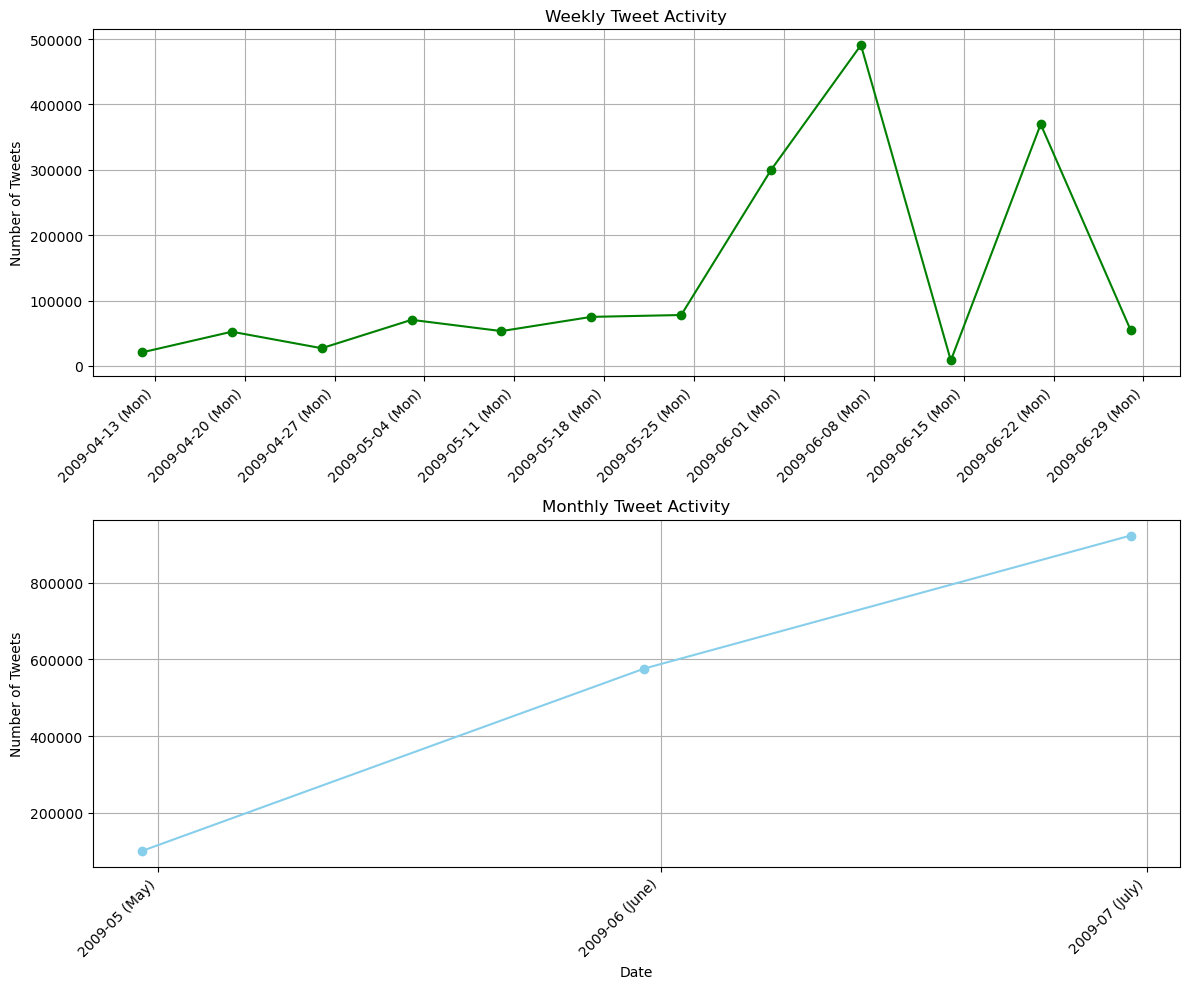

In [117]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Make a copy of the DataFrame for plotting 
trends_df = twitter_df.copy()
trends_df.set_index('date', inplace=True)  # Temporarily set the date as the index for resampling

# Resample the data by week and month 
weekly_tweets = trends_df.resample('W').size()
monthly_tweets = trends_df.resample('M').size()

# Creating the figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plotting weekly data
axs[0].plot(weekly_tweets.index, weekly_tweets, marker='o', linestyle='-', color='green')
axs[0].set_title('Weekly Tweet Activity')
axs[0].set_ylabel('Number of Tweets')
axs[0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d (%a)'))
axs[0].grid(True)

# Plotting monthly data
axs[1].plot(monthly_tweets.index, monthly_tweets, marker='o', linestyle='-', color='skyblue')
axs[1].set_title('Monthly Tweet Activity')
axs[1].set_ylabel('Number of Tweets')
axs[1].set_xlabel('Date')
axs[1].xaxis.set_major_locator(mdates.MonthLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m (%B)'))
axs[1].grid(True)

for ax in axs:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
plt.tight_layout()
plt.show()

#### Verifying April Data
Let's verify the presence and magnitude of April data in the DataFrame by specifically checking the entries for April or the earliest data points.

In [118]:
# Check the earliest dates in the DataFrame
print(twitter_df['date'].min())

# Check the number of tweets in the last few days of April if applicable
april_tweets = twitter_df[(twitter_df['date'] >= '2009-04-01') & (twitter_df['date'] <= '2009-04-30')]
print(april_tweets.shape)  # Give the number of tweets in April

2009-04-06 22:19:49
(100024, 4)


In [119]:
#!pip install plotly

In [120]:
import pandas as pd
import plotly.graph_objects as go

# Make a copy of the DataFrame for plotting 
trends_df = twitter_df.copy()
trends_df['date'] = pd.to_datetime(trends_df['date'])  
trends_df.set_index('date', inplace=True)  

# Resample the data by week and month
weekly_tweets = trends_df.resample('W').size().reset_index(name='counts')
monthly_tweets = trends_df.resample('M').size().reset_index(name='counts')
fig = go.Figure()

# Add weekly tweet activity trace
fig.add_trace(go.Scatter(x=weekly_tweets['date'], y=weekly_tweets['counts'],
                         mode='lines+markers', name='Weekly Tweets',
                         line=dict(color='green'), marker=dict(color='green')))

# Add monthly tweet activity trace
fig.add_trace(go.Scatter(x=monthly_tweets['date'], y=monthly_tweets['counts'],
                         mode='lines+markers', name='Monthly Tweets',
                         line=dict(color='skyblue'), marker=dict(color='skyblue')))
fig.update_layout(
    title='Tweet Activity: Weekly and Monthly Trends',
    xaxis=dict(
        title='Date',
        tickmode='auto',
        tickformat='%Y-%m-%d',
        tickangle=-45),
    yaxis=dict(
        title='Number of Tweets'),
    legend=dict(
        y=1, x=1,
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='rgba(0, 0, 0, 0.1)'))
fig.show()

The Plotly visualization appears to be anchored at the end of each month (like on 30/04/2009) and this is not displaying well in the context of analysis, let's adjust the data points to reflect the start of each month instead. This change can help in aligning the visualization more intuitively with the monthly progression, especially when viewed alongside weekly data that typically starts each week. When resample data by month in pandas, it by default assigns the result to the last day of the period. But it is possible to shift this to the first day by modifying the resample operation.

#### Adjusting the Monthly Data to Start of the Month
The line monthly_tweets['date'] = monthly_tweets['date'] adjusts monthly dates. - offsets.pd.MonthEnd(1) plus offsets for pd.Day 1 changes the monthly date so that it is now the first day of the month instead of the last. To make this adjustment, take one month-end offset and subtract it to move the date back to the beginning of the month. Then add one day.
Plotly graph with distinct labels for each time period, displaying both weekly and adjusted monthly data.

In [121]:
#Adjust dataset so that each monthly data point reflects the start of the month

import plotly.graph_objects as go
import pandas as pd

# Make a copy of the DataFrame for plotting
trends_df = twitter_df.copy()
trends_df['date'] = pd.to_datetime(trends_df['date'])
trends_df.set_index('date', inplace=True)  # Set the date as the index

# Resample the data by week and by month
weekly_tweets = trends_df.resample('W').size().reset_index(name='counts')
monthly_tweets = trends_df.resample('M').size().reset_index(name='counts')

# Shift the monthly data points to the start of each month
monthly_tweets['date'] = monthly_tweets['date'] - pd.offsets.MonthEnd(1) + pd.offsets.Day(1)

# Create figures for weekly and monthly tweet activity using Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=weekly_tweets['date'], y=weekly_tweets['counts'],
                         mode='lines+markers', name='Weekly Tweets',
                         line=dict(color='green'), marker=dict(color='green')))
fig.add_trace(go.Scatter(x=monthly_tweets['date'], y=monthly_tweets['counts'],
                         mode='lines+markers', name='Monthly Tweets',
                         line=dict(color='skyblue'), marker=dict(color='skyblue')))
# Update layout
fig.update_layout(
    title='Tweet Activity: Weekly and Monthly Trends',
    xaxis=dict(
        title='Date',
        tickmode='auto',
        tickformat='%Y-%m-%d',
        tickangle=-45),
    yaxis=dict(
        title='Number of Tweets'),
    legend=dict(
        y=1, x=1,
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='rgba(0, 0, 0, 0.1)'))

fig.show()

import matplotlib.pyplot as plt

# Create a box plot
plt.figure(figsize=(10, 6)) 
plt.boxplot(trends_df, vert=False, widths=0.7, patch_artist=True, flierprops={'marker':'o', 'color':'red', 'markersize':5})
plt.title('User ID Distribution')
plt.xlabel('User IDs')
plt.yticks([])  

# Enhance data-ink ratio
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)  
plt.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
plt.show()

#### Distributions
Explore the distribution of key variables using histograms or box plots to understand their central tendencies and spread.

#### Histograms: Useful for visualizing the distribution of numerical data.

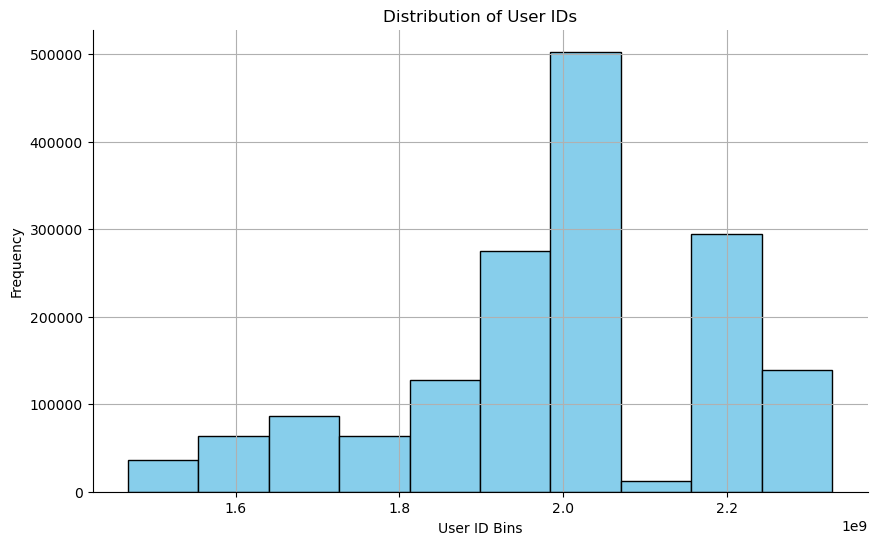

In [122]:
user_ids = twitter_df['user_id']

# Calculate histogram data
counts, bin_edges = np.histogram(user_ids, bins=10)

# Create a histogram
plt.figure(figsize=(10, 6))  
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), edgecolor='black', align='edge', color='skyblue')
plt.title('Distribution of User IDs')
plt.xlabel('User ID Bins')
plt.ylabel('Frequency')
plt.grid(True)

plt.tick_params(top=False, right=False, left=True, bottom=True, labelleft=True, labelbottom=True)
for spine in plt.gca().spines.values():
    if spine.spine_type not in ['bottom', 'left']:  
        spine.set_visible(False)

plt.show()

#### Box Plots: Good for detecting outliers and understanding the distribution's quartiles.

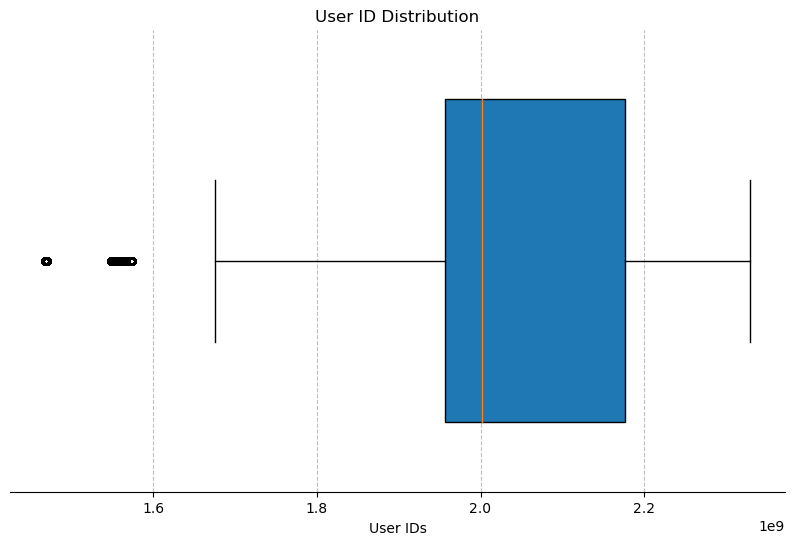

In [123]:
import matplotlib.pyplot as plt

# Create a box plot
plt.figure(figsize=(10, 6)) 
plt.boxplot(user_ids, vert=False, widths=0.7, patch_artist=True, flierprops={'marker':'o', 'color':'red', 'markersize':5})
plt.title('User ID Distribution')
plt.xlabel('User IDs')
plt.yticks([])  

# Enhance data-ink ratio
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)  
plt.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
plt.show()

#### Plot histograms and density plots of user_id to understand user engagement and presence. 
Because the histogram helps to visualize how active users are in terms of the number of tweets they post. And the density plot provides a clear view of the distribution's shape, highlighting the typical user activity levels without the binning process of a histogram.

First, set up correctly for visualising user activity using user_id and analysing the frequency of user interactions.

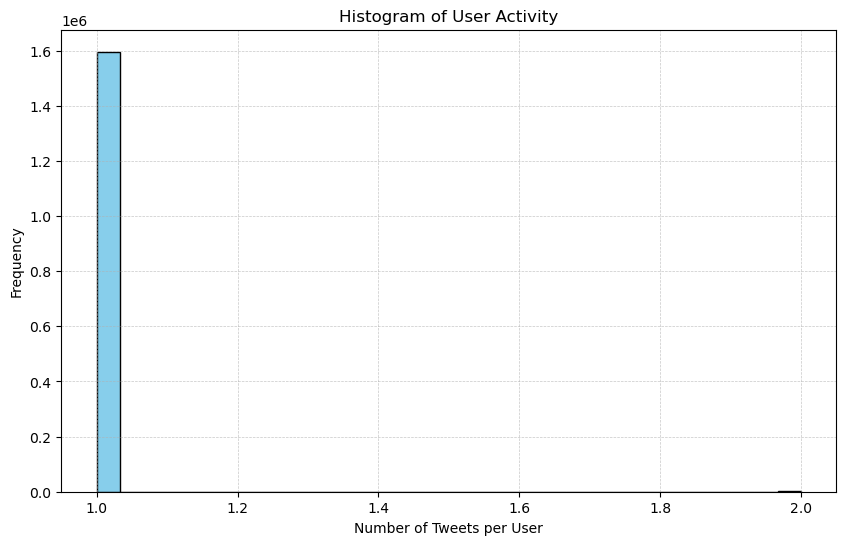

In [124]:
# Count the frequency of each user_id
user_activity = twitter_df['user_id'].value_counts()

import matplotlib.pyplot as plt

# Create a histogram of user activity
plt.figure(figsize=(10, 6))
plt.hist(user_activity.values, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of User Activity')
plt.xlabel('Number of Tweets per User')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Minimal grid use
plt.show()

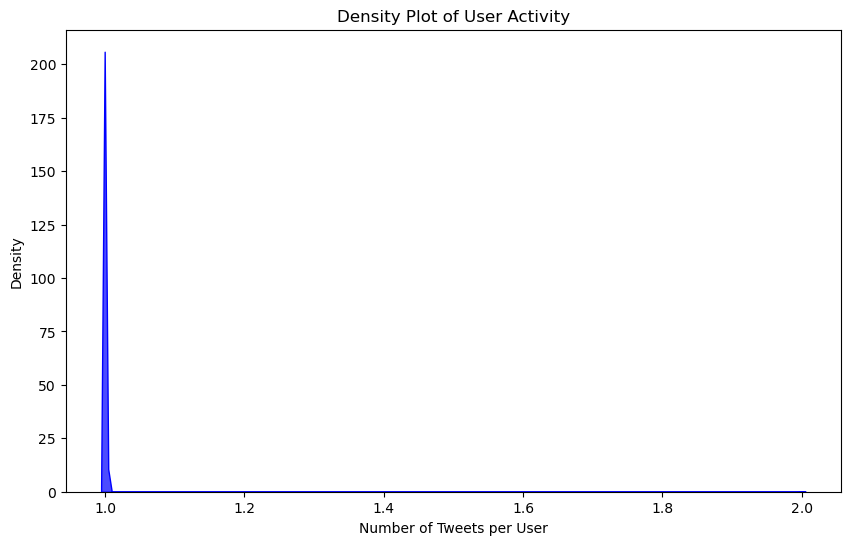

In [125]:
import seaborn as sns

# Create a density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(user_activity.values, shade=True, color='blue', alpha=0.7)
plt.title('Density Plot of User Activity')
plt.xlabel('Number of Tweets per User')
plt.ylabel('Density')
plt.show()

#### Pair Plots
Use pair plots to visualise the relationships and distributions of each pair of variables in the data.

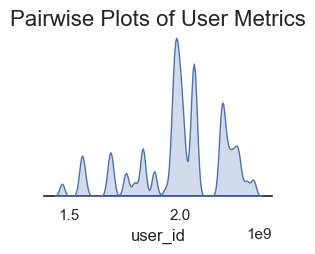

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pair plot with a clean and minimalist design
sns.set(style="white")  # Sets the style of the plot to a simple white background
pairplot = sns.pairplot(twitter_df, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80, 
                                                              'edgecolor': 'k'}, corner=True)
for i in range(len(pairplot.axes)):
    for j in range(len(pairplot.axes)):
        if i != j:
            pairplot.axes[i][j].set_visible(False)
            if i == j:
                pairplot.axes[i][j].set_ylabel('Density')

# Add titles and labels
plt.subplots_adjust(top=0.9)
pairplot.fig.suptitle('Pairwise Plots of User Metrics', fontsize=16)

plt.show()

#### Correlation Matrix
Investigate the correlations between numerical variables to better understand the links between the fields in the dataset.
Creating a correlation matrix is an excellent way to visually and quantitatively investigate the correlations between numerical variables in your dataset.

In [60]:
import pandas as pd

# Compute the correlation matrix
corr_matrix = twitter_df.corr()

# Print the correlation matrix
print(corr_matrix)

ValueError: could not convert string to float: 'scotthamilton'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap from the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)

# Enhancing the heatmap
plt.title('Correlation Matrix of Variables')
plt.yticks(rotation=0)  # Rotate y-labels for better readability
plt.xticks(rotation=90)  # Rotate x-labels for better readability
plt.show()

In [146]:
twitter_df.head(5)

,user_id,date,user_handle,tweet_text
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew


### Text Data Analysis
Analyzing the tweet texts, let's counting the number of words in each tweet.

Before calling, x (the tweet text) is explicitly converted to a string using `str(x).split()` is a helpful conversion because it guards against errors that could occur if non-string data were unintentionally included in the tweet_text. It guarantees that the.split() method, which splits the text into words based on spaces, always has a string to work on by first converting everything to a string.

#### Calculate the length of each tweet and the word count

In [313]:
# Create a copy of the DataFrame
temp_df = twitter_df.copy()

# Calculate word count and add it as a new column
temp_df['word_count'] = temp_df['tweet_text'].apply(lambda x: len(str(x).split()))
temp_df.head(5)

,user_id,date,user_handle,tweet_text,word_count
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...,21
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...,18
2,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,10
3,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all....",21
4,1467811372,2009-04-06 22:20:00,joy_wolf,@Kwesidei not the whole crew,5


The character count of each tweet and its total word count. An example of a moderately long tweet is the one by user "scotthamilton" in the first row, which has 111 characters and 21 words. The tweet from "joy_wolf" in the last row, on the other hand, is substantially shorter—just 29 characters and 5 words. These metrics are useful for examining tweet verbosity and content density. Applications such as sentiment analysis, user engagement research, and even social media language usage modelling can benefit from this kind of data.

### Histogram of Text Length and Word Count

Combined Histograms for Text Length and Word Count
Both measures are plotted in the same histogram and using different colors for distinction. This allows for direct comparison of distributions and also gives a clear visual comparison of the data.

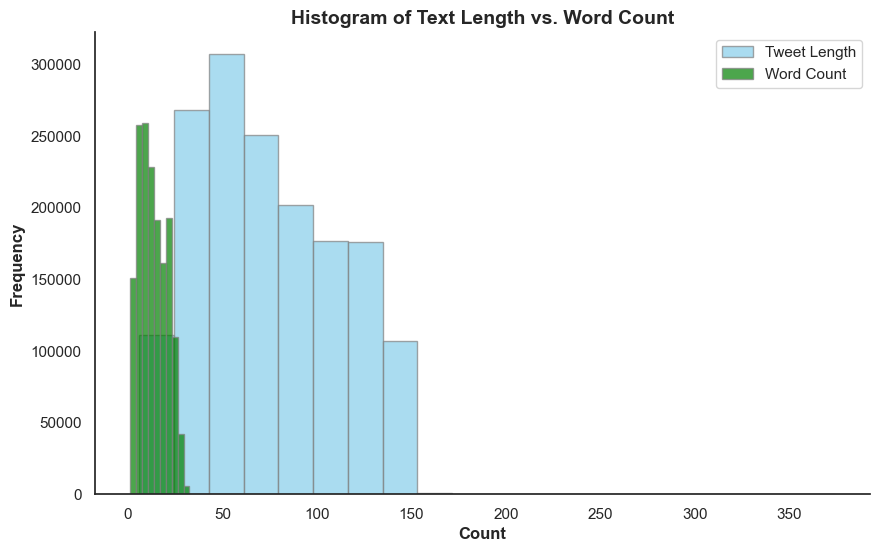

In [315]:
import pandas as pd
import matplotlib.pyplot as plt

temp_df['tweet_length'] = temp_df['tweet_text'].apply(len)  # Calculating tweet lengths.
temp_df['word_count'] = temp_df['tweet_text'].apply(lambda x: len(x.split()))  # Calculating word counts.

plt.figure(figsize=(10, 6))

# Plotting histograms on the same axes for comparison.
plt.hist(temp_df['tweet_length'], bins=20, alpha=0.7, label='Tweet Length', color='skyblue', edgecolor='grey')
plt.hist(temp_df['word_count'], bins=20, alpha=0.7, label='Word Count', color='green', edgecolor='grey')
plt.xlabel('Count', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Histogram of Text Length vs. Word Count', fontsize=14, fontweight='bold')
plt.legend()
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display the plot
plt.show()

### Sentiment Analysis

In [ ]:
#!pip install textblob

#### Text Cleaning
For sentiment analysis, text needs to be cleaned for better results.

In [316]:
import re

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower().strip()  # Convert to lower case and strip whitespaces
    return text

temp_df['clean_tweet_text'] = temp_df['tweet_text'].apply(clean_text)

#### TextBlob to add sentiment scores to the DataFrame.
TextBlob is a Python library for natural language processing (NLP). It uses NLTK (Natural Language Toolkit). When given a sentence, it returns two results: polarity and subjectivity.

In [317]:
# Use libraries TextBlob 
from textblob import TextBlob

# Function to get the polarity score
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

temp_df['sentiment'] = temp_df['clean_tweet_text'].apply(get_sentiment)

# Display the columns 'tweet_text', 'sentiment', and 'clean_tweet_text' 
temp_df[['tweet_text', 'sentiment', 'clean_tweet_text']].head(5)

,tweet_text,sentiment,clean_tweet_text
0,is upset that he can't update his Facebook by ...,0.000,is upset that he cant update his facebook by t...
1,@Kenichan I dived many times for the ball. Man...,0.500,i dived many times for the ball managed to sav...
2,my whole body feels itchy and like its on fire,0.200,my whole body feels itchy and like its on fire
3,"@nationwideclass no, it's not behaving at all....",-0.625,no its not behaving at all im mad why am i her...
4,@Kwesidei not the whole crew,0.200,not the whole crew


The code effectively cleans and processes text for sentiment analysis, allowing for more accurate interpretation of emotional content in tweets. The findings show that TextBlob can distinguish between various emotional tones in tweets, ranging from strong negativity to positivity, based on lexical content, making it a useful tool for analysing sentiment in social media texts. This preprocessing and analysis pipeline serves as a solid foundation for future sentiment-based applications such as trend analysis, customer feedback, and long-term monitoring of public opinion.

In [98]:
#TextBlob syntax to get polarity score:

res = TextBlob(sentence)

print(res.sentiment.polarity)

SyntaxError: invalid syntax (405066866.py, line 1)

#### Visualization of Sentiment Analysis Distribution
The plot counts the occurrences of each sentiment category in the DataFrame's'sentiment column and stores the results in the sentiment_counts variable. 

Rationale: The bar chart and printed sentiment counts are critical for quickly visualising and comprehending the distribution of emotions in a dataset, which is required for data-driven decisions. By clearly depicting the prevalence of negative, neutral, and positive sentiments, it quickly assesses public opinion, adjusts strategies as needed, and effectively communicates findings. This visualisation facilitates for further analysis.

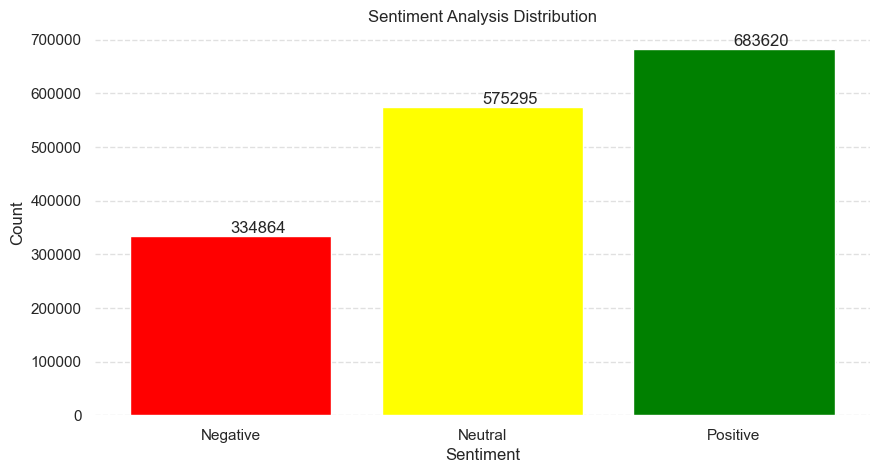

Sentiment Counts:
Negative Sentiment: 334864 occurrences
Neutral Sentiment: 575295 occurrences
Positive Sentiment: 683620 occurrences


In [318]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Binning the sentiment scores for plotting
sentiment_categories = pd.cut(temp_df['sentiment'], bins=[-1, -0.01, 0.01, 1], labels=['Negative', 'Neutral', 'Positive'])
sentiment_counts = sentiment_categories.value_counts()

# Sorting index to ensure the sentiments are plotted in logical order
sentiment_counts = sentiment_counts.reindex(['Negative', 'Neutral', 'Positive'])

# Plot the sentiments using color coding
colors = ['red', 'yellow', 'green']  # Red for Negative, Yellow for Neutral, Green for Positive
plt.figure(figsize=(10, 5))  
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)

# Add counts above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis Distribution')
plt.xticks(rotation=0)  
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Only horizontal grid
plt.box(False)
plt.show()


# Print the number of counts for each sentiment, formatted
print("Sentiment Counts:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment} Sentiment: {count} occurrences")

The bar chart illustrates the distribution of sentiment analysis results divided into three categories: negative, neutral, and positive. The y-axis represents the number of tweets in each category, while the x-axis categorises these counts by sentiment type.

Negative Sentiment: The red bar for negative sentiment indicates 334,864 occurrences. This list includes tweets analysed and classified as expressing negative emotions or opinions.

The neutral sentiment: is represented by a yellow bar with 575,295 occurrences. These tweets do not convey positive or negative emotions, implying a more factual, unemotional, or ambivalent tone.

Positive Sentiment: The positive sentiment, represented by a green bar, has the highest count, with 683,620 occurrences. This implies that a sizable proportion of the analysed tweets express positive emotions or opinions, indicating a generally favourable or approving tone.

In [319]:
print(temp_df['date'].head(5))

0   2009-04-06 22:19:49
1   2009-04-06 22:19:53
2   2009-04-06 22:19:57
3   2009-04-06 22:19:57
4   2009-04-06 22:20:00
Name: date, dtype: datetime64[ns]


The command `.head(5)` was applied due to this Error: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

In [ ]:
daily_sentiment = twitter_df['sentiment'].resample('D').mean()
daily_sentiment.plot(title='Daily Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

### VADER (Valence Aware Dictionary)
Use VADER (Valence Aware Dictionary) for sentiment analysis. The VADER was chosen because it is well-suited for social media text analysis due to its sensitivity to both polarity and emotional intensity.

#### Install Necessary Package
First, install nltk library, which includes the VADER sentiment analysis tool. 

Why this step is necessary:
The VADER lexicon is an essential component of the SentimentIntensityAnalyzer. It contains a list of lexical features (for example, words) labelled as positive or negative based on their semantic orientation. The lexicon also contains intensity modifiers, which adjust sentiment scores based on the context in which a word appears.

In [ ]:
#!pip install nltk
#!pip install nltk scikit-learn

####  Import Libraries and Load VADER
Import necessary libraries and download the VADER lexicon.

In [326]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rosil\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Clean text data for VADER Analysis
For typical use with English-language social media text, it is not necessary to perform extensive cleaning before using VADER for this case. However, a minimal cleaning might still be beneficial.

Applying a text cleaning function appropriate for VADER sentiment analysis, specifically retaining VADER-relevant features while removing irrelevant elements such as URLs and Twitter handles.

In [327]:
import re

# Create a copy of the DataFrame
vader_df = twitter_df.copy()

# Function to clean text data
def clean_text_for_vader(text):
    """
    Cleans the input text for optimal use with VADER sentiment analysis.
    - Removes URLs and Twitter handles which do not contribute to sentiment.
    - Retains emoticons, punctuation, and capitalization.
    """
    text = re.sub(r'http\S+', '', text)  # Removes URLs
    text = re.sub(r'@\w+', '', text)  # Removes Twitter handles
    return text

# Applying the cleaning function to the DataFrame
vader_df['cleaned_text'] = vader_df['tweet_text'].apply(clean_text_for_vader)

# Display the first few rows to verify the cleaning
print(vader_df[['tweet_text', 'cleaned_text']].head(5))

                                          tweet_text  \
0  is upset that he can't update his Facebook by ...   
1  @Kenichan I dived many times for the ball. Man...   
2    my whole body feels itchy and like its on fire    
3  @nationwideclass no, it's not behaving at all....   
4                      @Kwesidei not the whole crew    

                                        cleaned_text  
0  is upset that he can't update his Facebook by ...  
1   I dived many times for the ball. Managed to s...  
2    my whole body feels itchy and like its on fire   
3   no, it's not behaving at all. i'm mad. why am...  
4                                not the whole crew   


#### Define a Function to get sentiment scores and Apply the sentiment function

In [328]:
# Create a function that uses VADER to compute the sentiment scores.
def get_vader_sentiment(text):
    
    # VADER outputs a dictionary of scores; 'compound' gives the normalized sentiment score
    return sia.polarity_scores(text)['compound']

# The function to calculate sentiment scores for each tweet.
vader_df['vader_sentiment'] = vader_df['cleaned_text'].apply(get_vader_sentiment)

# Display the first few rows to check the sentiment scores results
print(vader_df[['cleaned_text', 'vader_sentiment']].head(5))

                                        cleaned_text  vader_sentiment
0  is upset that he can't update his Facebook by ...          -0.7500
1   I dived many times for the ball. Managed to s...           0.4939
2    my whole body feels itchy and like its on fire           -0.2500
3   no, it's not behaving at all. i'm mad. why am...          -0.6597
4                                not the whole crew            0.0000


#### Categorize Sentiment Scores
For evaluation with classification metrics, convert the continuous compound scores from VADER into categorical labels (e.g., 'positive', 'neutral', 'negative').

In [329]:
# Define a function to categorize sentiment based on the compound score
def categorize_sentiment(score):
    if score <= -0.05:  # Negative threshold
        return 'negative'
    elif score >= 0.05:  # Positive threshold
        return 'positive'
    else:
        return 'neutral'

# Apply the categorization function
vader_df['predicted_sentiment'] = vader_df['vader_sentiment'].apply(categorize_sentiment)

In [331]:
# Display the first few rows of the DataFrame to review the results
print(vader_df[['cleaned_text', 'vader_sentiment', 'predicted_sentiment']].head())

                                        cleaned_text  vader_sentiment  \
0  is upset that he can't update his Facebook by ...          -0.7500   
1   I dived many times for the ball. Managed to s...           0.4939   
2    my whole body feels itchy and like its on fire           -0.2500   
3   no, it's not behaving at all. i'm mad. why am...          -0.6597   
4                                not the whole crew            0.0000   

  predicted_sentiment  
0            negative  
1            positive  
2            negative  
3            negative  
4             neutral  


In [323]:
vader_df.head(1)

,user_id,date,user_handle,tweet_text,cleaned_text,vader_sentiment
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,-0.75


# Not finished 

#### Import metrics from Scikit-Learn and Evaluate Performance

Evaluate VADER's performance on the dataset by creating a confusion matrix and calculating precision, recall, and F1-scores.

First, import the necessary functions from scikit-learn to compute the confusion matrix and other classification metrics.

#### Manual Labeling for Evaluation
Manually label a random sample of the dataset to create a "ground truth" for evaluating VADER's performance.

In [95]:
# Sampling a subset for manual labeling
sampled_data = twitter_df.sample(100, random_state=1)  # Adjust sample size as needed

# Manual labels 
sampled_data['true_sentiment'] = ['positive', 'negative', 'neutral', ...]  # Fill this array after manual labeling

ValueError: Length of values (4) does not match length of index (100)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# The column 'true_sentiment' that contains the actual sentiment labels
true_labels = twitter_df['true_sentiment']
predicted_labels = twitter_df['predicted_sentiment']

#### Evaluate Performance
Generate the confusion matrix and classification report, which includes precision, recall, and F1-score for each sentiment category.

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['positive', 'neutral', 'negative'])
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, labels=['positive', 'neutral', 'negative'])
print("Classification Report:")
print(class_report)

In [76]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate the confusion matrix
cm = confusion_matrix(twitter_df['true_polarity'], twitter_df['predicted_sentiment'], labels=['positive', 'neutral', 'negative'])
print("Confusion Matrix:")
print(cm)

# Generate classification report
report = classification_report(twitter_df['true_polarity'], twitter_df['predicted_sentiment'], labels=['positive', 'neutral', 'negative'])
print("Classification Report:")
print(report)

KeyError: 'true_polarity'

## Time Series Analysis and Forecasting

Analysis: Sequential analysis of tweets may involve:

- Trend analysis is the process of tracking how specific topics, hashtags, or sentiments evolve over time.
- Event detection is the process of identifying spikes in activity that may be associated with specific events or announcements.
- Forecasting is the process of predicting future tweet volumes or sentiment trends using historical data.

#### Set Up Python Environment
Install pandas emoji for data manipulation and emoji to handle emojis specially.

In [182]:
#!pip install pandas emoji

#### Import libraries and Define a Text Cleaning Function for Time Series and Forecasting

To perform time series forecasting using this dataset, and given the need to apply at least two methods, including neural networks and autoregressive models, the approach to text cleaning and subsequent feature extraction must be efficient and effective. 
Given the complexity and noise of tweet data, the best cleaning approach should strive for simplicity while remaining effective, ensuring that the resulting text is appropriate for both machine learning and statistical models. Based on this criteria the code below was chosen. 

In [345]:
import pandas as pd
import re
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Create a copy of the DataFrame
new_twitter_df = twitter_df.copy()

# Download nltk's stopword list
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = emoji.demojize(text)           # Convert emojis to text
    text = re.sub(r'[^\w\s]', '', text)   # Remove punctuation
    text = re.sub(r'\b\d+\b', '', text)   # Remove numbers
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

new_twitter_df['clean_tweet_text'] = new_twitter_df['tweet_text'].apply(clean_text)
new_twitter_df.head(2)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rosil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rosil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,user_id,date,user_handle,tweet_text,clean_tweet_text
0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
1,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds


#### Drop unnecessary columns 
Non-essential columns such as `user_id`,`user_handle` and `tweet_text` are unnecessary for this time series forecasting. Both will drop and generate a new Dataframe. inplace=True)

In [346]:
# Drop unnecessary columns directly in the DataFrame
new_twitter_df.drop(['user_id', 'user_handle', 'tweet_text'], axis=1, inplace=True)

print(new_twitter_df.head(2))

                 date                                   clean_tweet_text
0 2009-04-06 22:19:49  upset cant update facebook texting might cry r...
1 2009-04-06 22:19:53  dived many times ball managed save rest go bounds


In [347]:
new_twitter_df.shape 

(1599999, 2)

#### Set Date as Index: For time series analysis, it's useful to have the date as the DataFrame index

In [348]:
import numpy as np

from pandas.tseries.offsets import Day
new_twitter_df.set_index('date', inplace=True)
new_twitter_df.head(2)

,clean_tweet_text
date,
2009-04-06 22:19:49,upset cant update facebook texting might cry r...
2009-04-06 22:19:53,dived many times ball managed save rest go bounds


#### Aggregate Daily Tweets: 
Aggregated by daily tweet counts, before applying imputation techniques.

In [349]:
new_twitter_df = new_twitter_df.resample('D').count()  # counting tweets per day
new_twitter_df.head(5)

,clean_tweet_text
date,
2009-04-06,3359
2009-04-07,17311
2009-04-08,0
2009-04-09,0
2009-04-10,0


#### Apply Specific Methods to Targeted Gaps
Identifying Gaps
First, detect where the gaps are and determine their sizes. This is crucial for applying the correct method:

In [351]:
# Create a column to identify gaps in data
new_twitter_df['gap_size'] = new_twitter_df['clean_tweet_text'].isnull().astype(int).groupby(new_twitter_df['clean_tweet_text'].notnull().astype(int).cumsum()).cumsum()

# Find start and end of each gap
gaps = new_twitter_df[new_twitter_df['gap_size'] > 0]
gap_ranges = gaps.groupby(gaps['gap_size'].ne(gaps['gap_size'].shift()).cumsum()).agg({'gap_size':'max', 'clean_tweet_text':'size'})
gap_ranges = gap_ranges[gap_ranges['clean_tweet_text'] > 0]  # Filtering actual gaps

#### Applying Methods
Seasonal Decomposition for Large Gaps (e.g., 10 days):

In [352]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose and fill large gaps
for start, end in large_gap_ranges:
    subset = twitter_df[start:end]
    decomposition = seasonal_decompose(subset['clean_tweet_text'], model='additive', period=7)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    twitter_df.loc[start:end, 'clean_tweet_text'] = (trend + seasonal).fillna(method='ffill')

NameError: name 'large_gap_ranges' is not defined

#### Linear Interpolation for Medium Gaps (e.g., 5-6 days):

In [ ]:
# Directly apply interpolation on specific gap indices
for start, end in medium_gap_ranges:
    twitter_df.loc[start:end, 'clean_tweet_text'] = twitter_df['clean_tweet_text'].interpolate(method='linear')

#### Forward Filling for Short Gaps (e.g., 2-3 days):

In [ ]:
# Forward fill for short gaps
for start, end in short_gap_ranges:
    twitter_df.loc[start:end, 'clean_tweet_text'] = twitter_df['clean_tweet_text'].fillna(method='ffill')

In [ ]:
#### Validate and Visualize
After applying the methods, it's important to validate that the gaps were filled appropriately:

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data to visually inspect gap filling
twitter_df['clean_tweet_text'].plot(figsize=(14, 7))
plt.title('Tweets Over Time After Gap Filling')
plt.show(

#### Preparing Data for Time Series Forecasting
Because the task requires forecasting based on tweet content, it is critical to consider how to convert the cleaned text into a format that can be used by both neural networks and ARIMA-type models.

To extract features from tweets, use TF-IDF instead of BoW. This method reduces the weight of frequent but less informative words. This can be especially useful in a short time series for focusing on impactful terms.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=100)  # Limiting to the top 100 features
tfidf_matrix = vectorizer.fit_transform(new_twitter_df['clean_tweet_text'])

# Convert TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.index = new_twitter_df.index
new_twitter_df.head(5)

Rationale:

Text Cleaning: The text cleaning steps are chosen to remove irrelevant noise from tweets, ensuring that the text-derived features are useful for analysis.
TF-IDF over BoW: TF-IDF is preferred because of its ability to highlight important words while reducing the impact of frequently appearing but less informative words, which is critical when analysing short-term data.


Forecasting Approach
ARIMA/SARIMA: Use these models to forecast based solely on time series data, such as tweet counts per day. They are useful for data in which previous values and trends (seasonal or otherwise) influence future values.
Consider an LSTM model that can use TF-IDF score sequences over time to predict future activity. As LSTMs are excellent at capturing patterns in sequential data.

In [ ]:
# Resample the data to daily frequency, filling missing dates with NaN, then forward fill
twitter_df = twitter_df.resample('D').first().fillna(method='ffill')

#### Aggregate Sentiment Over Time: 
Resample the sentiment data to daily, and calculate mean sentiment.

In [ ]:
#### Trend Analysis: 
Ploting time series of counts of tweets per day to see if there's any visible trend or seasonality.

In [ ]:
tweets_df.resample('D').size().plot(title='Daily Tweets')
plt.xlabel('Date')
plt.ylabel('Number of tweets')
plt.show()

### Seasonality Check: 
Use seasonal decomposition to observe inherent seasonality in the data.

In [156]:
#!pip install statsmodels

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(tweets_df.resample('D').size(), model='additive')
result.plot()
plt.show()

### Correlation and Causation Analysis

#### Stationarity Check: 
Ensure the time series data is stationary, as this is a requirement for models like ARIMA.

In [ ]:
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(daily_sentiment.dropna())
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

#### Time Series Plot of Tweet Frequency

In [ ]:
import matplotlib.pyplot as plt

# Plotting the number of tweets over time
twitter_df.set_index('date').resample('S').size().plot()
plt.title('Tweet Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Tweets')
plt.show()

### Time Series Preparation
Ensure the DataFrame is sorted by date and set the date as an index for time series analysis.

In [ ]:
twitter_df = twitter_df.sort_values(by='date')
twitter_df.set_index('date', inplace=True)
print(twitter_df.head())

### Forecasting:
Implement time series forecasting models such as ARIMA or LSTM

## Data Visualization and Reporting
Visualizing aspects of the data can further aid in understanding the distribution and relationships. 

Dynamic Dashboard Creation:
Use an appropriate tool like Plotly and Dash to create an interactive dashboard. Prepare the data in notebook and export it for visualization.

Documentation:
Document the findings, methods, and justifications in the report according to the project guidelines.

Visualization
Word Cloud
The word cloud provides a visual representation of the most frequent words in a text, with larger words indicating higher frequencies. By generating a word cloud, you can quickly grasp the key themes and prominent terms present in a dataset or document.
https://pub.aimind.so/a-comprehensive-guide-to-text-preprocessing-for-twitter-data-getting-ready-for-sentiment-analysis-e7f91cd03671

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Create a list of all tokens
all_tokens = [token for tokens_list in df['tokens'] for token in tokens_list]
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(nltk.FreqDist(all_tokens)))
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [354]:
https://pub.towardsai.net/sentiment-analysis-in-python-using-vader-c5bdcb233993
    
https://github.com/issBar/Sentiment-Time-Series-Prediction-in-Twitter-with-LSTM

SyntaxError: invalid syntax (3689918590.py, line 1)

References:

https://spark.apache.org/docs/latest/api/python/development/debugging.html#:~:text=1%202%204-,Py4j,its%20stack%20trace%2C%20as%20java.

Apache Parquet Documentation
The official documentation for the Parquet file format offers insights into its design, features, and benefits for using it in data storage and processing tasks.https://spark.apache.org/docs/latest/

Databricks Resources
Databricks, a company founded by the creators of Apache Spark, provides extensive resources, blogs, and tutorials on Spark and Parquet, including best practices for performance optimization.
Link: Databricks - Apache Spark Resources

This book by Holden Karau, Andy Konwinski, Patrick Wendell, and Matei Zaharia (O'Reilly Media) is a great resource to learn about Spark from the ground up, covering basic to advanced topics.
ISBN: 978-1449358624

Reference: https://www.nltk.org/_modules/nltk/sentiment/vader.html